# Classification on a subset of the Food 101 dataset

In [3]:
import os
from pathlib import Path
IMAGE_DIR = Path('./archive/images')

## Load dataset

Only load 3 chosen classes, we do not want to classify all 101 classes.

In [4]:
selected_classes = ["macarons", "french_fries", "hot_dog"]

filepaths = []
for category in selected_classes:
    category_path = IMAGE_DIR / category
    filepaths.extend(list(category_path.glob("*.jpg")))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


### Convert to dataframe

In [5]:
import pandas as pd

filepaths = pd.Series(filepaths, name='path').astype(str)
labels = pd.Series(labels, name='label')
images = pd.concat([filepaths, labels], axis=1)

print(f"Size of dataset: {labels.size}")
images.head()

Size of dataset: 3000


,path,label
0,archive\images\macarons\1001193.jpg,macarons
1,archive\images\macarons\1001527.jpg,macarons
2,archive\images\macarons\1003207.jpg,macarons
3,archive\images\macarons\1003224.jpg,macarons
4,archive\images\macarons\1004903.jpg,macarons


In [6]:
images['label'].value_counts()

label
macarons        1000
french_fries    1000
hot_dog         1000
Name: count, dtype: int64

## Split to train and test sets

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, train_size=0.8, shuffle=True, random_state=42)
train.size, test.size

(4800, 1200)

## Preprocess images

In [8]:
import tensorflow as tf
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1920 validated image filenames belonging to 3 classes.
Found 480 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


## Create model

In [44]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(len(selected_classes), activation='softmax'))


print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 52, 52, 16)        4624      
_________________________________________________________________
average_pooling2d_12 (Averag (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 16)      

## Compile model

In [45]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [46]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
60/60 [==============================] - 42s 686ms/step - loss: 1.0597 - accuracy: 0.4286 - val_loss: 1.0230 - val_accuracy: 0.4542
Epoch 2/25
60/60 [==============================] - 43s 722ms/step - loss: 0.9908 - accuracy: 0.5109 - val_loss: 0.9211 - val_accuracy: 0.5854
Epoch 3/25
60/60 [==============================] - 42s 706ms/step - loss: 0.9336 - accuracy: 0.5583 - val_loss: 0.9055 - val_accuracy: 0.5437
Epoch 4/25
60/60 [==============================] - 42s 696ms/step - loss: 0.9145 - accuracy: 0.5620 - val_loss: 0.9103 - val_accuracy: 0.5875
Epoch 5/25
60/60 [==============================] - 43s 713ms/step - loss: 0.8866 - accuracy: 0.5859 - val_loss: 0.8884 - val_accuracy: 0.5813
Epoch 6/25
60/60 [==============================] - 42s 701ms/step - loss: 0.8937 - accuracy: 0.5760 - val_loss: 0.8857 - val_accuracy: 0.6146
Epoch 7/25
60/60 [==============================] - 42s 703ms/step - loss: 0.8413 - accuracy: 0.6073 - val_loss: 0.8833 - val_accuracy: 0.5979

## Evaluate model

In [47]:
loss, accuracy = model.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 4s 214ms/step - loss: 0.8934 - accuracy: 0.6400
Test loss: 0.89
Test accuracy: 64.00%


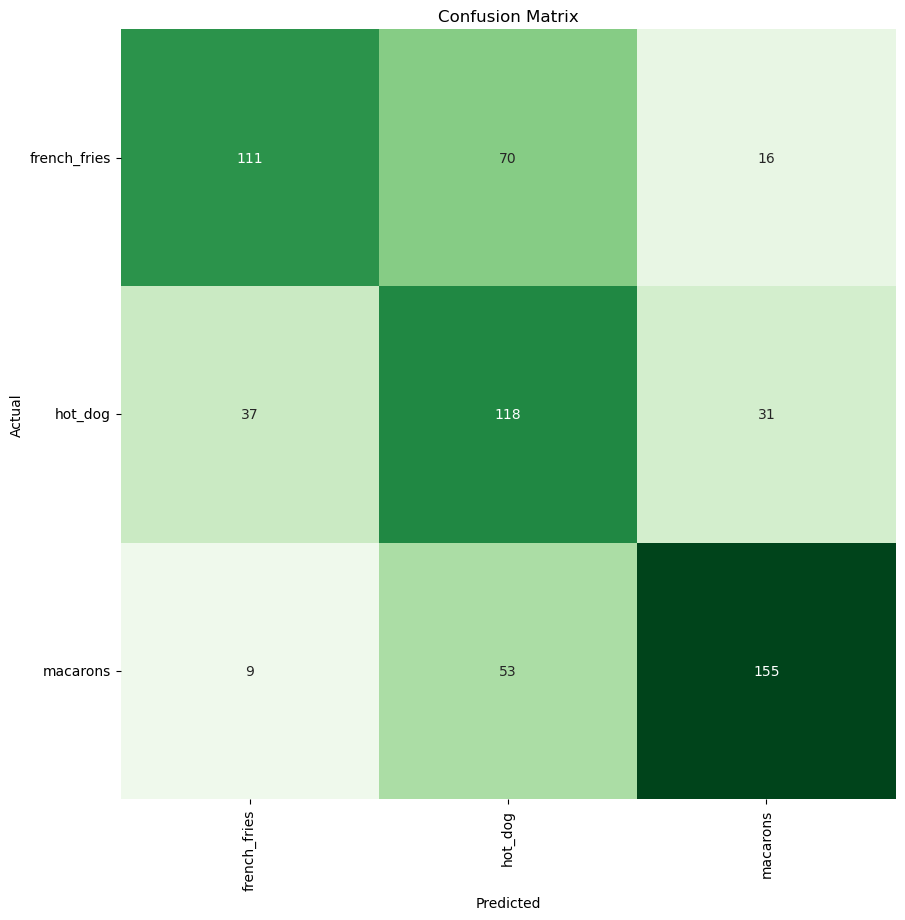

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

french_fries       0.71      0.56      0.63       197
     hot_dog       0.49      0.63      0.55       186
    macarons       0.77      0.71      0.74       217

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.66      0.64      0.64       600

